# 09-2 순환 신경망으로 IMDB 리뷰 분류하기
##### 텐서플로를 사용해 순환 신경망을 만들어 영화 리뷰 데이터셋에 적용해서 리뷰를 긍부정으로 분류합니다.

- IMDB 리뷰 데이터셋으로 가장 간단한 순환 신경망 모델을 훈련
- 두 가지 방법 사용 :
  - 원 핫 인코딩
  - 단어 임베딩

- 이 절에서 사용할 IMDB 리뷰 데이터셋을 적재해보자
![rnn-14](./images/rnn-500-1.jpg)

### IMDB 리뷰 데이터셋 
- 영화db인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍, 부정으로 분류
- 5만개 샘플, 훈련/테스트 데이터에 각 25,000개씩 나뉘어 있음
- 말뭉치 : 자연어 처리 분야에서 훈련 데이터를 말함
- 신경망에 텍스트 데이터를 고유한 숫자로 변경
![rnn-15](./images/rnn-501-1.jpg)

- He를 10, cat을 13으로 매핑(정숫값 사이에는 어떤 관계도 없음)
- 토큰(token) : 분리된 단어
- 하나의 샘플은 여러 개의 토큰으로 이루어지고 1개의 토큰이 하나의 타임스텝에 해당

- 토큰에 할당하는 정수 중 몇개는 특정 용도로 예약됨
  - 0은 패딩, 1은 문장의 시작, 2는 어휘 사전에 없는 토큰
  - 어휘 사전 : 훈련 세트에서 고유한 단어를 뽑아 만든 목록 (테스트 세트 안에 어휘 사전에 없는 단어가 있다면 2로 변환)
- IMDB 리뷰 데이터셋은 영어로 된 문장이지만 텐서플로에는 이미 정수로 바꾼 데이터가 포함되어 있음 

In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

2024-01-13 11:18:58.874498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=300)

17464789/17464789 [==============================] - 14s 1us/step


In [3]:
# 훈련 세트, 테스트 세트 크기 확인
print(train_input.shape, test_input.shape)

(25000,) (25000,)


- IMDB 리뷰 텍스트는 길이가 제각각임. 고정 크기의 2차원 배열보다 별도의 파이썬 리스트를 담아 메모리 효율적으로 사용
![rnn-16](./images/rnn-502-1.jpg)

- 넘파이 배열은 정수, 실수, 파이썬 객체를 담을 수 있음

In [5]:
# 첫 번째 리뷰 길이 확인 (218개 토큰)
print(len(train_input[0]))

218


In [6]:
# 두 번째 리뷰 길이 확인
print(len(train_input[1]))

189


In [7]:
# 첫 번째 리뷰 내용 출력
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


- num_words=300으로 지정했기 때문에 어휘 사전에는 300개 단어만 들어가 있음
- 책에서는 500개를 기준으로 단어를 지정
  - imdb.load_data() 함수는 전체 어휘 사전에 있는 단어를 등장 횟수로 순서대로 나열한 다음 가장 많이 등장한 500개 단어를 선택
- 이제 타깃 데이터를 출력해보자

In [8]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


- 긍부정을 판단하므로 이진 분류 문제로 접근. 0(부정), 1(긍정)
- 이제 데이터를 더 살펴보기 전에 훈련 세트에서 검증 세트를 떼어 놓자
- 20% 검증 세트로 훈련 세트 크기는 2만개로 줄어들 것

In [9]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

- 훈련 세트를 조사
  - 평균 리뷰의 길이와 가장 짧은, 긴 리뷰 확인

In [10]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [11]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


- 평균 단어 개수 239, 중간값 178 -> 좌편향 분포
- 히스토그램으로 표현해보자

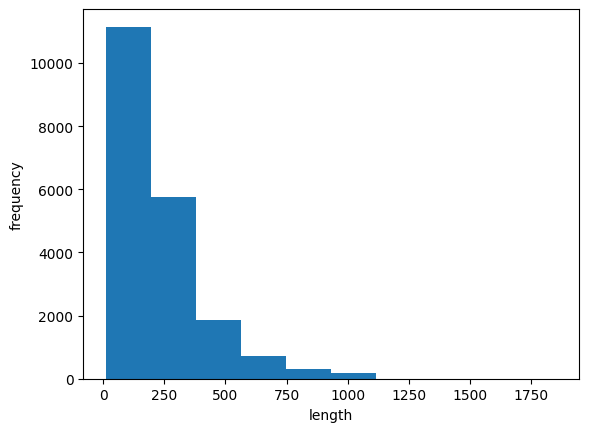

In [12]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

- 대부분 리뷰길이는 300 미만
- 평균이 중간값보다 높은 이유는 오른쪽 끝에 아주 큰 데이터가 있기 때문
- 리뷰는 대부분 짧으니 중간값보다 훨씬 짧은 100개 단어만 사용
- 100개보다 짧은 리뷰를 100에 맞추기 위해 패딩 사용 (패딩 토큰으로 0을 사용)
- 함수로 편하게 작업이 가능함

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

In [14]:
# train_seq 크기 확인
print(train_seq.shape)

(20000, 100)


- 아래의 그림과 같은 2차원 배열이 되었음
![rnn-17](./images/rnn-506-1.jpg)

- 첫 번쨰 샘플 확인

In [15]:
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


- 어느 부분이 짤렸는지 확인 (앞부분, 뒷부분)

In [17]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


- train_input[0]에 있는 마지막 10개 토큰 출력
- pad_sequences() 함수는 기본으로 maxlen보다 긴 시퀀스 앞부분을 자름
- 뒷부분을 자르고 싶다면 pad_sequendces() 함수의 truncating 매개변수를 post로 변경
- 6번째 샘플 확인

In [18]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94 205   2  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 샘플 길이가 100이 안되는 것을 확인 (앞부분 0)
- 이제 검증 세트 길이를 100으로 맞추자

In [27]:
val_seq = pad_sequences(val_input, maxlen=100)

### 순환 신경망 만들기
- SimpleRNN 클래스 사용
- 이진분류이므로 1개 뉴런을 가지고 시그모이드 활성화 함수 사용해야 함
- 먼저 케라스 Sequential 클래스 신경망 코드를 보자

In [19]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

- input_shape 의 100은 샘플의 길이, 300은 잠시 후 설명
- 순환층도 활성화 함수 사용
  - SimpleRNN 클래스의 activation 매개변수 기본값은 tanh를 그대로 사용
  - 300 차원은 정수값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하기 위한 원-핫 인코딩임
    ![rnn-18](./images/rnn-509-1.jpg)

  - imdb.load_data() 함수에서 300개 단어만 사용하도록 지정했기 때문에 고유 단어는 모두 300개임 + 0(패딩 토큰)까지 배열의 총 길이는 300
  - 케라스에 원-핫 인코딩 배열을 반환

In [20]:
train_oh = keras.utils.to_categorical(train_seq)

In [23]:
# 배열의 크기 출력
print(train_oh.shape)

(20000, 100, 300)


- 정수마다 모두 300 차원의 배열로 변경  -> (20000, 100) 크기 train_seq가 (20000, 100, 500) 크기 train_oh로 변경
- 샘플 데이터 크기가 1차원 정수 배열(100,)에서 2차원 배열(100,300)으로 바뀌어야 하므로 SimpleRNN 클래스 input_shape 매개변수 값을 (100, 300)으로 지정
- 첫 번째 샘플의 첫 토큰 10이 잘 출력되었는지 확인

In [24]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [25]:
# 모든 원소 값을 더해 1이 되는지 확인
print(np.sum(train_oh[0][0]))

1.0


In [28]:
# 같은 방식으로 val_seq도 원-핫 인코딩으로 변경
val_oh = keras.utils.to_categorical(val_seq)

In [30]:
# 모델 구조 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 2472      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2481 (9.69 KB)
Trainable params: 2481 (9.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- SimpleRNN에 전달할 샘플 크기는 (100, 500)이지만 순환층 마지막 타임스텝의 은틱 상태만 출력
- 순환층에 사용된 모델 파라미터 개수 계산
  - 입력 토큰 300차원의 원-핫 인코딩 배열
  - 이 배열이 순환층의 뉴런 8개와 완전히 연결되기 때문에 300 X 8 = 2400개 가중치가 있음
  - 순환층 은닉 상태는 다시 다음 타임스텝에 사용되기 위해 또 다른 가중치와 곱해짐
  - 이 은닉 상태도 순환층 뉴런과 완전히 연결되기 떄문에 8 (은닉 상태 크기) X 8 (뉴런 개수) = 64개 가중치 필요
  - 뉴런마다 하나의 절편이 있음
  - 모두 2400 + 64 + 8 = 2472 모델 파라미터가 필요

### 순환 신경망 훈련하기
- 훈련하는 방법은 다른 신경망과 동일
- 이 예에서 기본 RMSprop 학습률 0.001을 사용하지 않기 위해 RMSProp 객체를 만들어 학습률 0.0001로 지정
- 에포크 횟수를 100으로 늘리고 배치 크기는 64로 설정

In [31]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 17ms/step - loss: 0.7003 - accuracy: 0.5002 - val_loss: 0.6970 - val_accuracy: 0.5058
Epoch 2/100
 10/313 [..............................] - ETA: 4s - loss: 0.6994 - accuracy: 0.5031

/Users/jeremyshin/.pyenv/versions/3.11.3/envs/hongong/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 5s 16ms/step - loss: 0.6956 - accuracy: 0.5123 - val_loss: 0.6946 - val_accuracy: 0.5124
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6917 - accuracy: 0.5282 - val_loss: 0.6909 - val_accuracy: 0.5318
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6844 - accuracy: 0.5549 - val_loss: 0.6833 - val_accuracy: 0.5690
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6784 - accuracy: 0.5778 - val_loss: 0.6797 - val_accuracy: 0.5770
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6732 - accuracy: 0.5892 - val_loss: 0.6755 - val_accuracy: 0.5844
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6680 - accuracy: 0.6063 - val_loss: 0.6695 - val_accuracy: 0.5974
Epoch 8/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6616 - accuracy: 0.6195 - val_loss: 0.6632 - val_accuracy: 0.6112
Epoc

- 책에서는 서른 다섯 번째 에포크에서 조기 종료
- 검증 세트 정확도는 약 80% 정도
- 감상평을 분류하는데 어느 정도 성과 있는 것을 판단 가능
- 이제 훈련 손실과 검증 손실을 그래프로 그려서 훈련 과정을 살펴보자

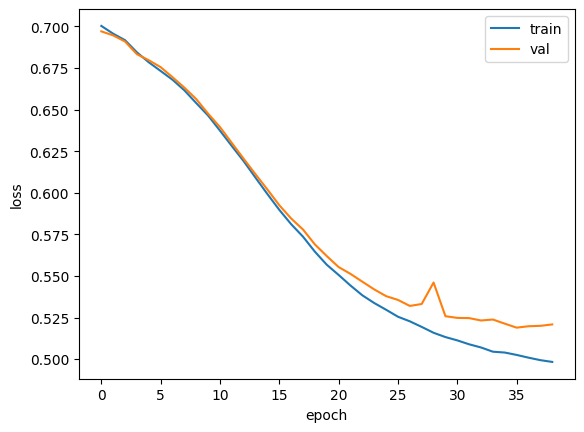

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 훈련 손실은 꾸준히 감소하지만 대략 스무 번쨰 에포크에서 감소가 둔해짐
- 위 작업의 단점은 원-핫 인코딩의 단점은 입력 데이터가 엄청 커진다는 것

In [33]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 2400000000


- 토큰 1개를 300차원으로 늘렸기 때문에 300배가 커짐
- 다음 장에서 더 좋은 방법을 알아보자

### 단어 임베딩을 사용하기
- 단어 임베딩 : 각 단어를 고정된 크기의 실수 벡터로 바꿔줌
  ![rnn-19](./images/rnn-514-1.jpg)

- 단어 임베딩은 원-핫 인코딩과 비교하여 의미 있는 값으로 채워져있어 자연어 처리에서 더 좋은 성능을 냄
- 케라스에서 Embedding 클래스로 임베딩 기능을 제공
- 장점 : 입력으로 정수를 받음 -> train_seq를 사용할 수 있음 메모리 훨씬 효율적으로 사용 (배열 X)
- 임베딩도 (100,) 크기 샘플을 (100, 20)과 같이 2차원 배열로 늘리지만 훨씬 작은 크기로 단어를 잘 표현 가능

In [34]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(300, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           4800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5009 (19.57 KB)
Trainable params: 5009 (19.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- Embedding 클래스 첫 매개변수(300)은 어휘 사전의 크기
  - 앞선 단어와 같이 설정(비교를 위해)
- 두 번째 매개변수(16)은 임베딩 벡터의 크기
  - 원-핫 인코딩보다 훨씬 작은 크기(16)의 벡터를 사용
- 세 번째  input_length 매개변수는 입력 시퀀스의 길이 : 앞서 길이를 100으로 맞춰 train_seq를 만듦
- summery() 메서드 출력에서 알 수 있듯 이 모델은 (100,) 크기 입력을 받아(100,16) 크기 출력을 만듦
- 300 X 16 = 4800개 모델 파라미터를 가짐
- 임베딩 백터 크기 16, 8개 뉴런 -> 16 X 8 = 128개를 가지고 은닉 상태 가중치 8 X 8 = 64개, 마지막 8개의 절편으로 전체 모델 파라미터 개수는 200
- 마지막 덴스 층의 가중치 개수는 이전과 동일한 9개
- 이제 모델을 훈련해보자

In [35]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6893 - accuracy: 0.5351 - val_loss: 0.6706 - val_accuracy: 0.5872
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6399 - accuracy: 0.6467 - val_loss: 0.6234 - val_accuracy: 0.6664
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6051 - accuracy: 0.6941 - val_loss: 0.6003 - val_accuracy: 0.6948
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5831 - accuracy: 0.7172 - val_loss: 0.5888 - val_accuracy: 0.7026
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5663 - accuracy: 0.7305 - val_loss: 0.5669 - val_accuracy: 0.7300
Epoch 6/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5527 - accuracy: 0.7408 - val_loss: 0.5536 - val_accuracy: 0.7356
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5410 - accuracy: 0.7475 - val_loss: 0.5422 - val_accuracy:

- 출력 결과를 보면 원-핫 인코딩 사용 모델과 비슷한 성능
- 반면 순환층의 가중치 개수는 훨씬 작고 훈련 세트 크기도 크게 줄어듦
- 마지막으로 훈련 손실과 검증 손실을 그래프로 그려보자

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 손실이 더 감소되지 않아 훈련이 적절히 조기 종료됨을 확인
- 이를 더 개선할 방법을 다음 절에서 확인